# Exploratory Data Analysis

## Import Dataset

In [1]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import pandas as pd

# Load application data
df = pd.read_csv('application_train.csv')

# Display first few rows
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Struktur Dataset

In [2]:
# Menampilkan 5 baris pertama dataset
print("5 Baris Pertama Dataset Home Credit:")
print(df.head())

# Menampilkan informasi dasar tentang dataset
print("\nInformasi Dataset:")
print(df.info())

# Menampilkan jumlah baris dan kolom
print(f"\nJumlah Baris: {df.shape[0]}, Jumlah Kolom: {df.shape[1]}")

# Menampilkan tipe data setiap kolom
print("\nTipe Data Setiap Kolom:")
print(df.dtypes)

# Menampilkan jumlah nilai yang hilang per kolom
print("\nJumlah Nilai yang Hilang per Kolom:")
print(df.isnull().sum())

5 Baris Pertama Dataset Home Credit:
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \


# Penanganan Missing Values dan Data Cleaning

## Penanganan Missing Values

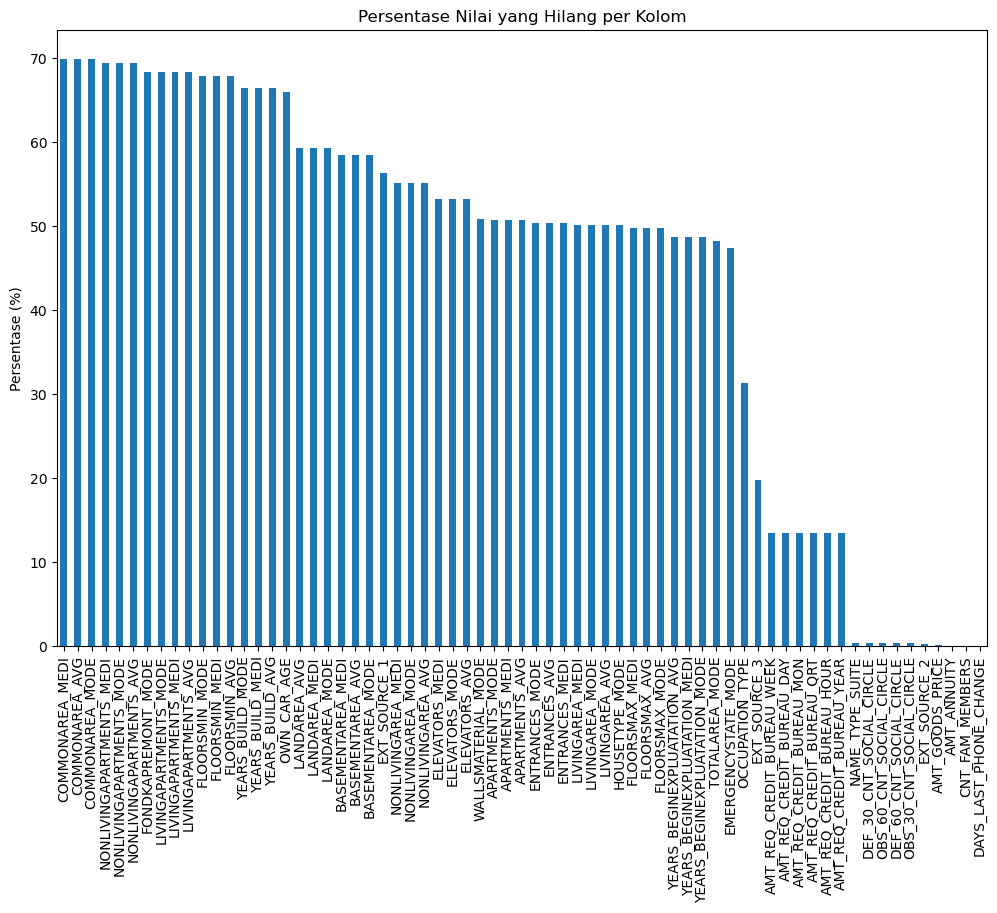


Kolom dengan nilai yang hilang lebih dari 50%:
COMMONAREA_MEDI                 69.872297
COMMONAREA_AVG                  69.872297
COMMONAREA_MODE                 69.872297
NONLIVINGAPARTMENTS_MEDI        69.432963
NONLIVINGAPARTMENTS_MODE        69.432963
NONLIVINGAPARTMENTS_AVG         69.432963
FONDKAPREMONT_MODE              68.386172
LIVINGAPARTMENTS_MODE           68.354953
LIVINGAPARTMENTS_MEDI           68.354953
LIVINGAPARTMENTS_AVG            68.354953
FLOORSMIN_MODE                  67.848630
FLOORSMIN_MEDI                  67.848630
FLOORSMIN_AVG                   67.848630
YEARS_BUILD_MODE                66.497784
YEARS_BUILD_MEDI                66.497784
YEARS_BUILD_AVG                 66.497784
OWN_CAR_AGE                     65.990810
LANDAREA_AVG                    59.376738
LANDAREA_MEDI                   59.376738
LANDAREA_MODE                   59.376738
BASEMENTAREA_MEDI               58.515956
BASEMENTAREA_AVG                58.515956
BASEMENTAREA_MODE           

In [3]:
import matplotlib.pyplot as plt

# Menghitung persentase nilai yang hilang per kolom
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

# Visualisasi nilai yang hilang
plt.figure(figsize=(12, 8))
missing_percent.plot(kind='bar')
plt.title('Persentase Nilai yang Hilang per Kolom')
plt.ylabel('Persentase (%)')
plt.show()

print("\nKolom dengan nilai yang hilang lebih dari 50%:")
print(missing_percent[missing_percent > 40])

In [4]:
# Drop kolom dengan missing > 60%
threshold = 0.6  # 60%
df_drop = df.loc[:, df.isnull().mean() < threshold]
print(f'Shape sebelum drop kolom: {df.shape}')
print(f'Shape setelah drop kolom: {df_drop.shape}')

Shape sebelum drop kolom: (307511, 122)
Shape setelah drop kolom: (307511, 105)


In [5]:
from sklearn.impute import SimpleImputer

# Misalkan df_drop adalah subset dari df (contoh)
df_drop = df.copy()  # Pastikan df_drop adalah salinan independen

# Identifikasi kolom numerik
numerical_cols = df_drop.select_dtypes(include=['int64', 'float64']).columns

# Imputasi kolom numerik
imputer_num = SimpleImputer(strategy='mean')
df_drop.loc[:, numerical_cols] = imputer_num.fit_transform(df_drop[numerical_cols])

In [6]:
df_drop = df.copy()  # Gunakan .copy() untuk menghindari view

# Imputasi untuk kolom numerik
numerical_cols = df_drop.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in ['TARGET', 'SK_ID_CURR']]

# Menggunakan median untuk imputasi (karena lebih robust terhadap outlier)
imputer_num = SimpleImputer(strategy='median')
df_drop.loc[:, numerical_cols] = imputer_num.fit_transform(df_drop[numerical_cols])

In [7]:
# Memeriksa apakah masih ada missing values
print("Jumlah missing values:")
print(df_drop.isnull().sum().sum())

Jumlah missing values:
764371


## Penghapusan Outlier

In [8]:
# Fungsi untuk analisis outlier
def analyze_outliers(df_drop, columns, threshold=1.5):
    outlier_report = {}
    
    for col in columns:
        Q1 = df_drop[col].quantile(0.25)
        Q3 = df_drop[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outliers = df_drop[(df_drop[col] < lower_bound) | (df_drop[col] > upper_bound)]
        
        outlier_report[col] = {
            'n_outliers': len(outliers),
            'pct_outliers': f"{len(outliers)/len(df)*100:.2f}%",
            'min_val': df_drop[col].min(),
            'max_val': df_drop[col].max(),
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }
    
    return pd.DataFrame(outlier_report).T

key_columns = [
    'AMT_INCOME_TOTAL', 
    'AMT_CREDIT', 
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED'
]

# Analisis outlier
outlier_analysis = analyze_outliers(df, key_columns)
print("Analisis Outlier Awal:")
display(outlier_analysis)

Analisis Outlier Awal:


,n_outliers,pct_outliers,min_val,max_val,lower_bound,upper_bound
AMT_INCOME_TOTAL,14035,4.56%,25650.0,117000000.0,-22500.0,337500.0
AMT_CREDIT,6562,2.13%,45000.0,4050000.0,-537975.0,1616625.0
AMT_ANNUITY,7504,2.44%,1615.5,258025.5,-10584.0,61704.0
AMT_GOODS_PRICE,14728,4.79%,40500.0,4050000.0,-423000.0,1341000.0
DAYS_BIRTH,0,0.00%,-25229,-7489,-30585.5,-1509.5
DAYS_EMPLOYED,72217,23.48%,-17912,365243,-6466.5,3417.5


In [9]:
import numpy as np
def winsorize_data(df, columns, threshold=1.5):
    """
    Mengganti outlier dengan nilai batas menggunakan pendekatan winsorizing
    threshold: 3.0 untuk lebih longgar (3 x IQR)
    """
    df_clean = df.copy()
    
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Capping
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    return df_clean

# Terapkan winsorizing
df_no_outliers= winsorize_data(df_drop, key_columns, threshold=3.0)


Analisis Setelah Penanganan Outlier:


,n_outliers,pct_outliers,min_val,max_val,lower_bound,upper_bound
AMT_INCOME_TOTAL,14035,4.56%,25650.0,117000000.0,-22500.0,337500.0
AMT_CREDIT,6562,2.13%,45000.0,4050000.0,-537975.0,1616625.0
AMT_ANNUITY,7504,2.44%,1615.5,258025.5,-10584.0,61704.0
AMT_GOODS_PRICE,14728,4.79%,40500.0,4050000.0,-423000.0,1341000.0
DAYS_BIRTH,0,0.00%,-25229,-7489,-30585.5,-1509.5
DAYS_EMPLOYED,72217,23.48%,-17912,365243,-6466.5,3417.5


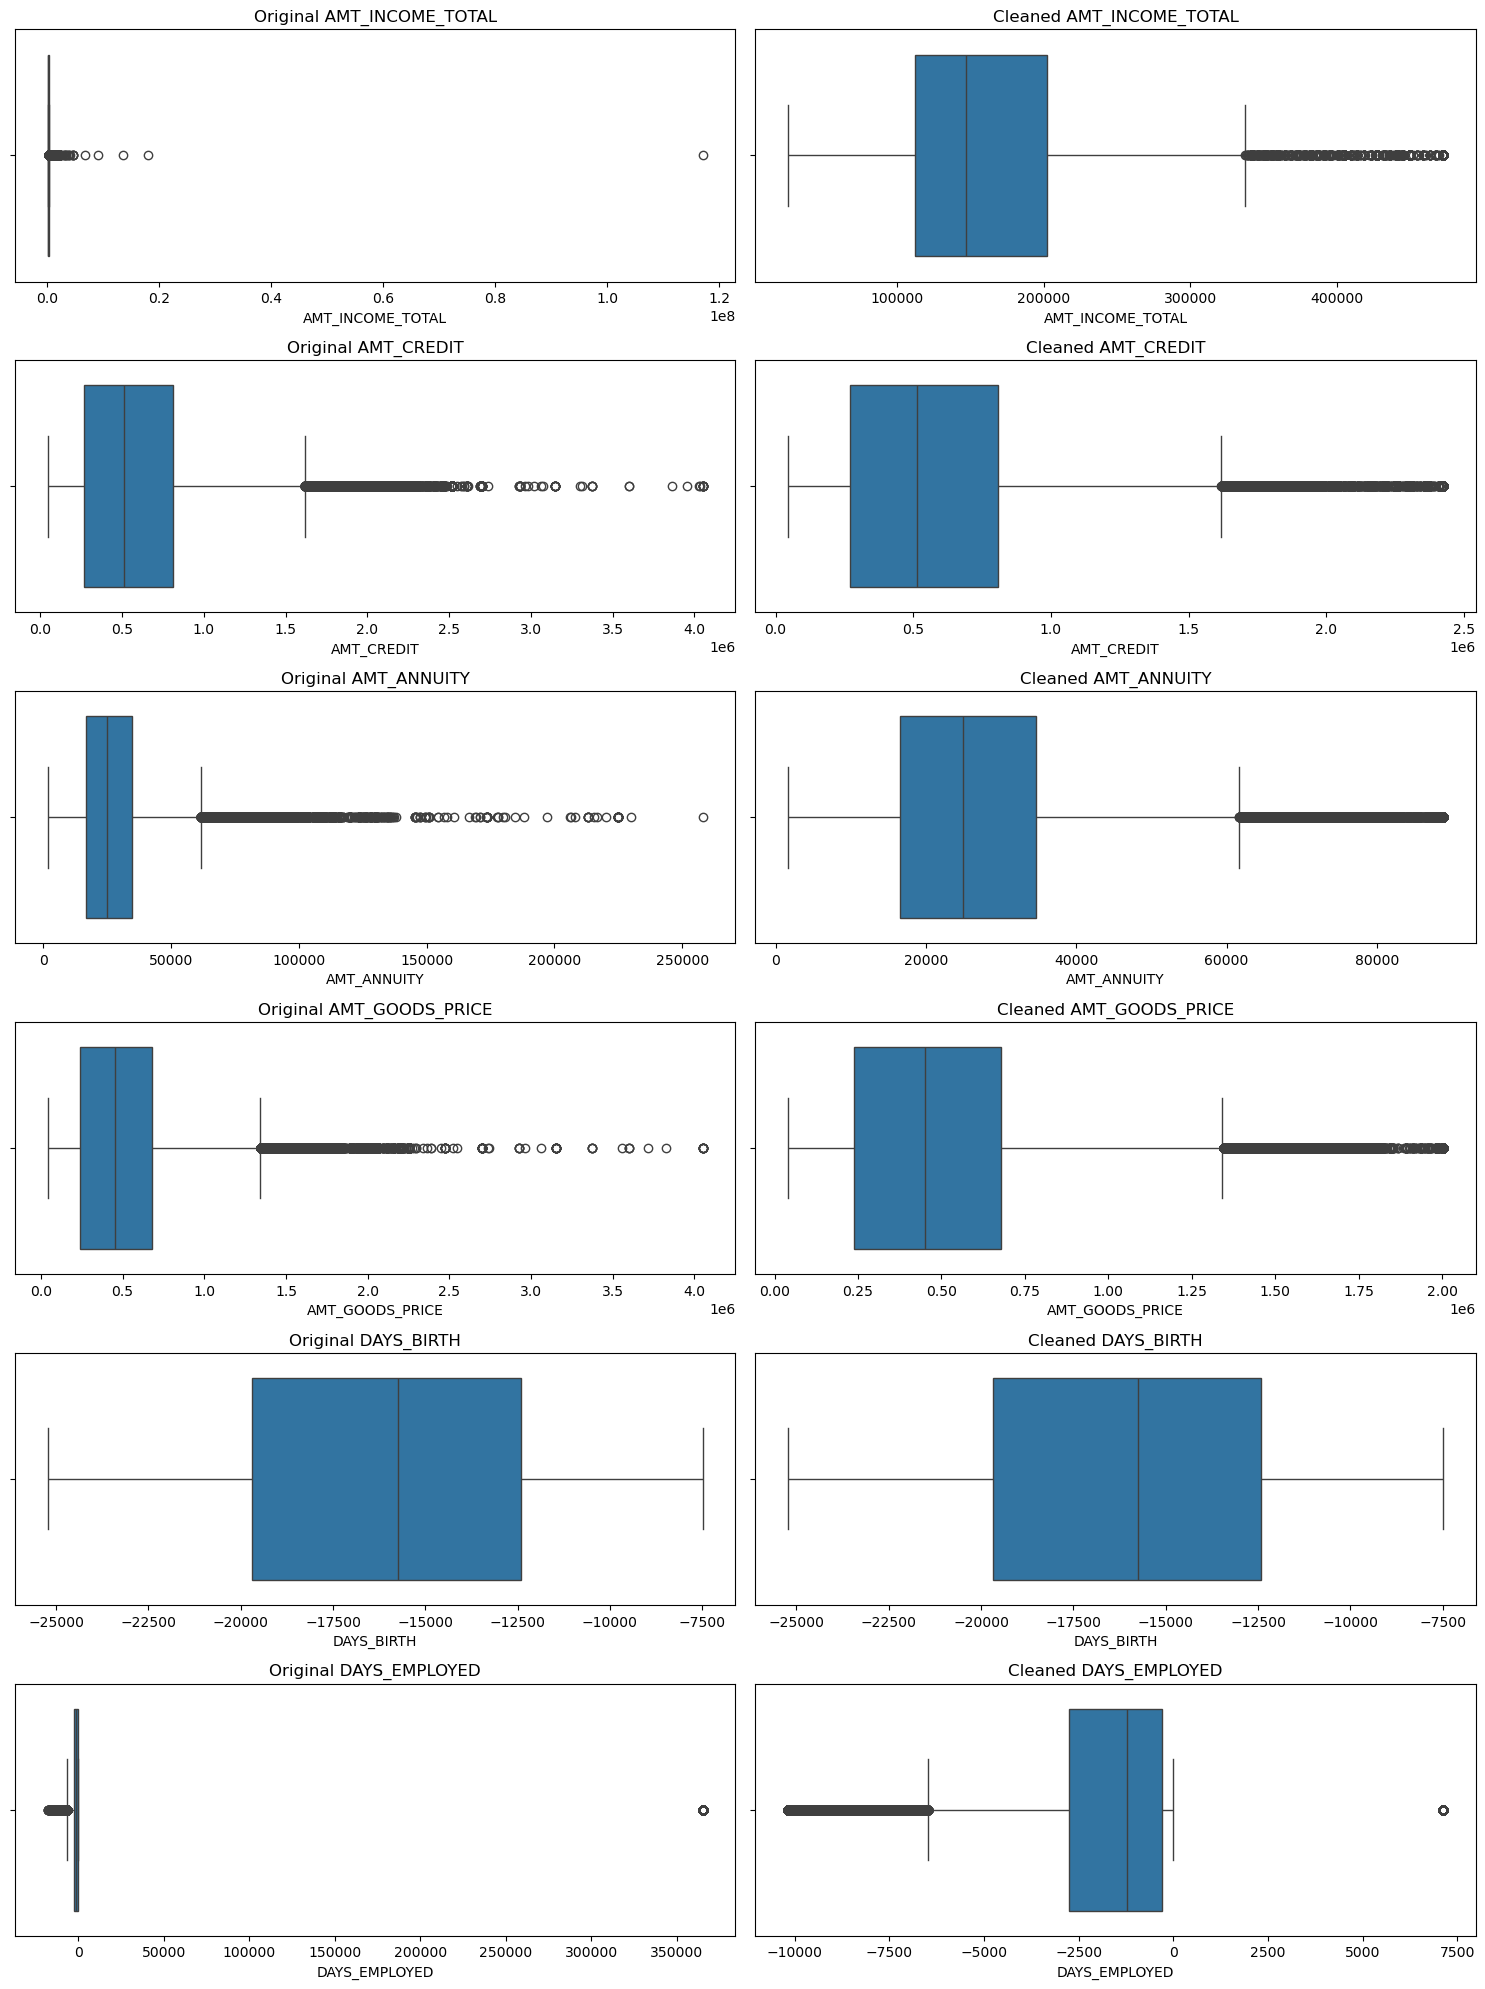


Dimensi dataset sebelum cleaning: (307511, 122)
Dimensi dataset setelah cleaning: (307511, 122)


In [10]:
import seaborn as sns

# Analisis setelah penanganan
print("\nAnalisis Setelah Penanganan Outlier:")
outlier_analysis_clean = analyze_outliers(df_drop, key_columns)
display(outlier_analysis_clean)

# Visualisasi perbandingan
fig, axes = plt.subplots(len(key_columns), 2, figsize=(15, 20))
for i, col in enumerate(key_columns):
    # Sebelum
    sns.boxplot(x=df_drop[col], ax=axes[i, 0])
    axes[i, 0].set_title(f'Original {col}')
    
    # Sesudah
    sns.boxplot(x=df_no_outliers[col], ax=axes[i, 1])
    axes[i, 1].set_title(f'Cleaned {col}')
    
plt.tight_layout()
plt.show()

# Periksa ukuran dataset
print(f"\nDimensi dataset sebelum cleaning: {df_drop.shape}")
print(f"Dimensi dataset setelah cleaning: {df_no_outliers.shape}")

In [11]:
# Verifikasi untuk satu kolom contoh
col = key_columns[0]  # ambil kolom pertama

Q1 = df_drop[col].quantile(0.25)
Q3 = df_drop[col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3.0 * IQR
upper_bound = Q3 + 3.0 * IQR

# Cek apakah masih ada nilai di luar bounds
outliers_exist = ((df_no_outliers[col] < lower_bound) | (df_no_outliers[col] > upper_bound)).any()
print(f"Apakah masih ada outlier di kolom {col} setelah winsorizing? {outliers_exist}")

# Cek nilai min/max sebelum dan sesudah
print(f"\nKolom: {col}")
print(f"Sebelum - Min: {df_drop[col].min()}, Max: {df_drop[col].max()}")
print(f"Sesudah - Min: {df_no_outliers[col].min()}, Max: {df_no_outliers[col].max()}")

Apakah masih ada outlier di kolom AMT_INCOME_TOTAL setelah winsorizing? False

Kolom: AMT_INCOME_TOTAL
Sebelum - Min: 25650.0, Max: 117000000.0
Sesudah - Min: 25650.0, Max: 472500.0


# Transformasi dan Rekayasa Fitur

## Encoding Variabel Kategorikal

In [12]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Memisahkan kolom kategorikal
categorical_cols = df_no_outliers.select_dtypes(include=['object']).columns

# One-Hot Encoding untuk kolom dengan cardinality rendah (<10 nilai unik)
low_cardinality_cols = [col for col in categorical_cols if df_no_outliers[col].nunique() < 10]

# Label Encoding untuk kolom dengan cardinality tinggi
high_cardinality_cols = [col for col in categorical_cols if df_no_outliers[col].nunique() >= 10]

# Melakukan One-Hot Encoding
df_encoded = pd.get_dummies(df_no_outliers, columns=low_cardinality_cols, drop_first=True)

# Melakukan Label Encoding untuk kolom dengan cardinality tinggi
label_encoder = LabelEncoder()
for col in high_cardinality_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col].astype(str))

print("\nShape setelah encoding:", df_encoded.shape)


Shape setelah encoding: (307511, 158)


## Normalisasi & Standarisasi

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Memisahkan fitur dan target
X = df_encoded.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_encoded['TARGET']

# Daftar kolom numerik untuk diskalakan
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Standarisasi (Z-score normalization)
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Alternatif: Normalisasi Min-Max
# minmax_scaler = MinMaxScaler()
# X[numeric_cols] = minmax_scaler.fit_transform(X[numeric_cols])

print("\nContoh data setelah standarisasi:")
print(X[numeric_cols].head())


Contoh data setelah standarisasi:
   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0     -0.577538          0.439112   -0.479199    -0.166412        -0.510725   
1     -0.577538          1.251745    1.732722     0.616017         1.622519   
2     -0.577538         -1.186154   -1.156557    -1.443461        -1.102608   
3     -0.577538         -0.373521   -0.713421     0.188307        -0.658696   
4     -0.577538         -0.536048   -0.213834    -0.368102        -0.066813   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                   -0.149452    1.506880       0.002459           0.379837   
1                   -1.252750   -0.166821      -0.130061           1.078697   
2                   -0.783451   -0.689509       0.101549           0.206116   
3                   -0.928991   -0.680114      -0.575245          -1.375829   
4                    0.563570   -0.892535      -0.575004           0.191639   

   DAYS_ID_PUBL

## Fitur Baru

In [14]:
# Membuat fitur baru: Rasio Kredit terhadap Pendapatan
df_encoded['CREDIT_INCOME_RATIO'] = df_encoded['AMT_CREDIT'] / df_encoded['AMT_INCOME_TOTAL']

# Membuat fitur baru: Rasio Anuitas terhadap Pendapatan
df_encoded['ANNUITY_INCOME_RATIO'] = df_encoded['AMT_ANNUITY'] / df_encoded['AMT_INCOME_TOTAL']

# Membuat fitur baru: Usia dalam tahun (dari DAYS_BIRTH)
df_encoded['AGE_YEARS'] = abs(df_encoded['DAYS_BIRTH']) / 365

# Membuat fitur baru: Lama bekerja dalam tahun (dari DAYS_EMPLOYED)
df_encoded['WORKING_YEARS'] = abs(df_encoded['DAYS_EMPLOYED']) / 365

# Membuat fitur baru: Persentase hari bekerja dari usia
df_encoded['WORKING_LIFE_RATIO'] = abs(df_encoded['DAYS_EMPLOYED']) / abs(df_encoded['DAYS_BIRTH'])

# Memeriksa fitur baru
print("\nFitur baru yang dibuat:")
new_features = ['CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'AGE_YEARS', 'WORKING_YEARS', 'WORKING_LIFE_RATIO']
print(df_encoded[new_features].describe())


Fitur baru yang dibuat:
       CREDIT_INCOME_RATIO  ANNUITY_INCOME_RATIO      AGE_YEARS  \
count        307511.000000         307511.000000  307511.000000   
mean              3.962897              0.181026      43.936973   
std               2.684737              0.094020      11.956133   
min               0.095238              0.008700      20.517808   
25%               2.027183              0.115270      34.008219   
50%               3.275862              0.162933      43.150685   
75%               5.159467              0.228800      53.923288   
max              84.736842              1.875965      69.120548   

       WORKING_YEARS  WORKING_LIFE_RATIO  
count  307511.000000       307511.000000  
mean        8.802426            0.186891  
std         7.444760            0.135954  
min         0.000000            0.000000  
25%         2.556164            0.068385  
50%         6.079452            0.155791  
75%        15.635616            0.305463  
max        27.871233       

In [15]:
df_encoded.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,CREDIT_INCOME_RATIO,ANNUITY_INCOME_RATIO,AGE_YEARS,WORKING_YEARS,WORKING_LIFE_RATIO
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461.0,-637.0,...,False,False,True,False,False,2.007889,0.121978,25.920548,1.745205,0.067329
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765.0,-1188.0,...,False,False,False,False,False,4.790750,0.132217,45.931507,3.254795,0.070862
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046.0,-225.0,...,False,False,False,False,False,2.000000,0.100000,52.180822,0.616438,0.011814
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005.0,-3039.0,...,False,False,False,False,False,2.316167,0.219900,52.068493,8.326027,0.159905
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932.0,-3038.0,...,False,False,False,False,False,4.222222,0.179963,54.608219,8.323288,0.152418


# Data Splitting

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Memisahkan fitur dan target
X = df_encoded.drop('TARGET', axis=1)
y = df_encoded['TARGET']

# Menampilkan statistik awal
print("=== Statistik Data Awal ===")
print(f"Jumlah total sampel: {len(df)}")
print(f"Jumlah fitur: {X.shape[1]}")
print("\nDistribusi kelas:")
print(y.value_counts(normalize=True))

=== Statistik Data Awal ===
Jumlah total sampel: 307511
Jumlah fitur: 162

Distribusi kelas:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


## Pembagian Data Training (75%) dan Testing (25%) dengan Stratified Sampling

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler  # For balancing

# Menampilkan statistik awal (from your previous code)
print("=== Statistik Data Awal ===")
print(f"Jumlah total sampel: {len(df)}")
print(f"Jumlah fitur: {X.shape[1]}")
print("\nDistribusi kelas:")
print(y.value_counts(normalize=True))

# Balance the dataset using RandomOverSampler before splitting
print("\n=== Balancing Dataset ===")
balancer = RandomOverSampler(random_state=42)
X_balanced, y_balanced = balancer.fit_resample(X, y)

# Menampilkan distribusi kelas setelah balancing
print("Distribusi kelas setelah balancing:")
print(y_balanced.value_counts(normalize=True))
print(f"Jumlah total sampel setelah balancing: {len(y_balanced)}")

# Pembagian data dengan stratified sampling on the balanced dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, 
    y_balanced, 
    test_size=0.25, 
    random_state=42,  # Untuk reproducibility
    stratify=y_balanced  # Stratified sampling to maintain balanced distribution
)

# Menampilkan statistik hasil pembagian
print("\n=== Hasil Pembagian Data ===")
print(f"Jumlah data training: {len(X_train)} ({len(X_train)/len(y_balanced)*100:.1f}%)")
print(f"Jumlah data testing: {len(X_test)} ({len(X_test)/len(y_balanced)*100:.1f}%)")

print("\nDistribusi kelas pada data training:")
print(y_train.value_counts(normalize=True))

print("\nDistribusi kelas pada data testing:")
print(y_test.value_counts(normalize=True))

=== Statistik Data Awal ===
Jumlah total sampel: 307511
Jumlah fitur: 162

Distribusi kelas:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

=== Balancing Dataset ===
Distribusi kelas setelah balancing:
TARGET
1    0.5
0    0.5
Name: proportion, dtype: float64
Jumlah total sampel setelah balancing: 565372

=== Hasil Pembagian Data ===
Jumlah data training: 424029 (75.0%)
Jumlah data testing: 141343 (25.0%)

Distribusi kelas pada data training:
TARGET
1    0.500001
0    0.499999
Name: proportion, dtype: float64

Distribusi kelas pada data testing:
TARGET
0    0.500004
1    0.499996
Name: proportion, dtype: float64


## 10-Fold Cross Validation Stratified

In [18]:
# 10-fold stratified cross validation
skf = StratifiedKFold(
    n_splits=10,
    shuffle=True,
    random_state=42
)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\nFold {fold + 1}:")
    print(f"  Training: index {train_idx[0]}..{train_idx[-1]}")
    print(f"  Validation: index {val_idx[0]}..{val_idx[-1]}")
    print(f"  Class distribution in validation: {np.bincount(y_train.iloc[val_idx])}")


Fold 1:
  Training: index 0..424028
  Validation: index 2..424019
  Class distribution in validation: [21201 21202]

Fold 2:
  Training: index 1..424028
  Validation: index 0..424016
  Class distribution in validation: [21201 21202]

Fold 3:
  Training: index 0..424028
  Validation: index 3..424021
  Class distribution in validation: [21201 21202]

Fold 4:
  Training: index 0..424028
  Validation: index 4..424014
  Class distribution in validation: [21201 21202]

Fold 5:
  Training: index 0..424028
  Validation: index 16..424022
  Class distribution in validation: [21201 21202]

Fold 6:
  Training: index 0..424027
  Validation: index 8..424028
  Class distribution in validation: [21202 21201]

Fold 7:
  Training: index 0..424028
  Validation: index 7..424027
  Class distribution in validation: [21202 21201]

Fold 8:
  Training: index 0..424028
  Validation: index 1..424017
  Class distribution in validation: [21202 21201]

Fold 9:
  Training: index 0..424028
  Validation: index 5..424

## Transformasi Data (Standardisasi)

In [19]:
# Transformasi data (standardisasi)
scaler = StandardScaler()

# Hanya fit pada data training untuk menghindari data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Konversi kembali ke DataFrame untuk mempertahankan nama kolom
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("\nContoh data setelah standardisasi:")
print(X_train_scaled.head())


Contoh data setelah standardisasi:
   SK_ID_CURR  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0    0.841006     -0.594451         -0.349979   -0.706380    -0.866935   
1    1.027013     -0.594451          1.222391    0.677565    -0.167082   
2   -0.832234      2.118561          3.580945   -1.083270    -0.645022   
3    0.374957      0.762055          0.492362    0.483705     3.433516   
4    0.565818     -0.594451          1.334703    0.393253     0.885063   

   AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        -0.810918                   -1.156608   -0.786805       0.117918   
1         0.533182                    2.010613   -1.004400       2.045980   
2        -1.074467                   -0.823734    0.611029      -0.942896   
3         0.638601                    0.392654    0.346955      -0.254546   
4         0.467295                   -0.641699   -0.713965      -0.304574   

   DAYS_REGISTRATION  ...  WALLSMATERIAL_MODE_Others  \


## Verifikasi Pembagian Data

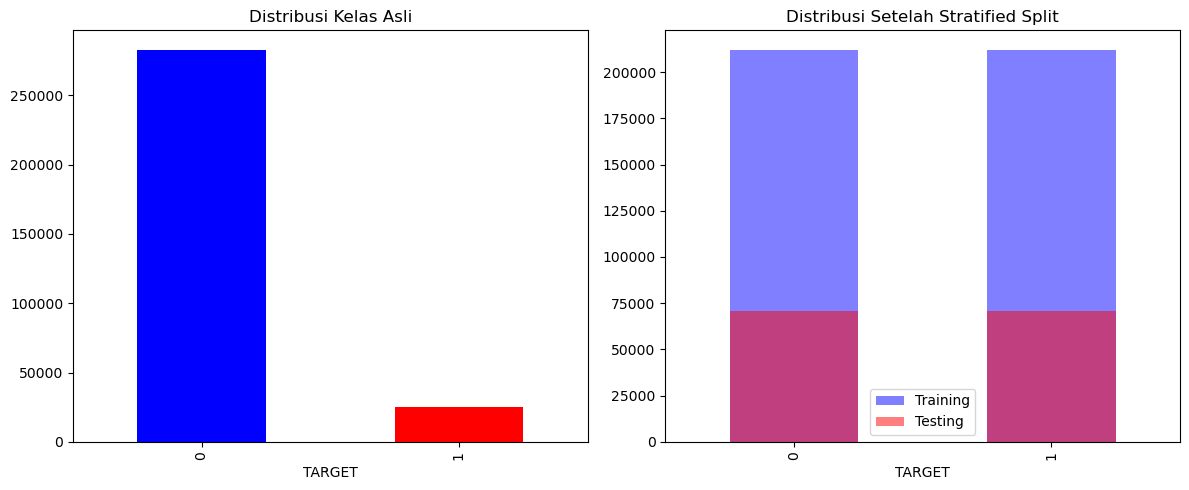

In [20]:
# Visualisasi pembagian data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Distribusi kelas asli
plt.subplot(1, 2, 1)
y.value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribusi Kelas Asli')

# Distribusi setelah split
plt.subplot(1, 2, 2)
pd.Series(y_train).value_counts().plot(kind='bar', color='blue', alpha=0.5, label='Training')
pd.Series(y_test).value_counts().plot(kind='bar', color='red', alpha=0.5, label='Testing')
plt.title('Distribusi Setelah Stratified Split')
plt.legend()

plt.tight_layout()
plt.show()